In [138]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_validate
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.inspection import permutation_importance
from shap import TreeExplainer
from scipy import sparse


from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, 
    classification_report, confusion_matrix,
    confusion_matrix, roc_auc_score, 
    average_precision_score, precision_recall_curve,
    precision_recall_fscore_support,
)


import importlib
import fonctions.fonctions_features as ff
importlib.reload(ff)
from fonctions.fonctions_features import FeatureEngineer, ColumnDropper

import fonctions.fonctions_CV as funcCV
importlib.reload(funcCV)
from fonctions.fonctions_CV import perm_importance_cv, get_transformed_feature_names_and_source_map


In [139]:
data = pd.read_csv("data/jeu_donnee_RH_complet_transforme.csv")

In [149]:
#code réutilisé dans l'ensemble des cellules

cols_a_supprimer = [
   "hors_entreprise_majoritaire", 
   "perf_degrade_flag", 
   "perf_degrade_niv", 
   "a_connu_mvmnt_interne", 
   "genre",
    "heure_supplementaires", 
    "pee_participation_flag", 
    "pee_participation_2plus", 
    "revenu_mensuel"
]

thr = 0.40

over = SMOTE(sampling_strategy=0.2, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)

In [141]:
#DUMMY

# --- 2) Préparation des données d’entrée 
data_pd = data.copy()

X = data_pd.drop(columns=["a_quitte_l_entreprise"])
y = data_pd["a_quitte_l_entreprise"].map({"Non": 0, "Oui": 1}).astype(int)

# --- 3) Pipeline complète avec TON FE + préprocessing classique + XGB ---
numeric_sel = selector(dtype_include=["number", "bool"])   # inclut les bools comme numériques
categorical_sel = selector(dtype_exclude=["number", "bool"])

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())   # centrage + mise à l'échelle des numériques
        ]), numeric_sel),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore")),
        ]), categorical_sel),
    ],
    remainder="drop",
)

pipe_dummy = Pipeline(steps=[
    ("fe", FeatureEngineer()),   # <- ton feature engineering, sans fuite
    ("prep", preprocess),
    ("clf", DummyClassifier(strategy="most_frequent", random_state=42)),
])

# --- 4A) En TRAIN / TEST "clas
# sique" (pas de fuite) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe_dummy.fit(X_train, y_train) 

y_pred_dummy = pipe_dummy.predict(X_test)

# --- 4B) En Cross-Validation stratifiée (pas de fuite) ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ("precision", "recall", "roc_auc")
scores = cross_validate(
    pipe_dummy, X, y, cv=cv,
    scoring=("precision", "recall", "roc_auc"),
    return_train_score=True
)

print("\n=== Dummy ===")

for m in scoring:
    tr_mean, tr_std = scores[f"train_{m}"].mean(), scores[f"train_{m}"].std()
    te_mean, te_std = scores[f"test_{m}"].mean(), scores[f"test_{m}"].std()
    print(f"[{m}] train={tr_mean:.3f}±{tr_std:.3f} | test={te_mean:.3f}±{te_std:.3f}")

proba_te = pipe_dummy.predict_proba(X_test)[:, 1]
y_pred_06 = (proba_te >= thr).astype(int)

print(f"\n-- RAPPORT (seuil à {thr}) --")
print(classification_report(y_test, y_pred_06, digits=3, zero_division=0))

print("-- MATRICE DE CONFUSION --")
print(confusion_matrix(y_test, y_pred_06))  # [[tn, fp], [fn, tp]]

print("-- AUCs (seuil-indep.) --")
print(f"ROC AUC (test) = {roc_auc_score(y_test, proba_te):.3f}")
print(f"PR AUC  (test) = {average_precision_score(y_test, proba_te):.3f}")

c:\Users\thoma\AppData\Local\pypoetry\Cache\virtualenvs\projet4-KgNUqIF9-py3.13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\thoma\AppData\Local\pypoetry\Cache\virtualenvs\projet4-KgNUqIF9-py3.13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\thoma\AppData\Local\pypoetry\Cache\virtualenvs\projet4-KgNUqIF9-py3.13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` 


=== Dummy ===
[precision] train=0.000±0.000 | test=0.000±0.000
[recall] train=0.000±0.000 | test=0.000±0.000
[roc_auc] train=0.500±0.000 | test=0.500±0.000

-- RAPPORT (seuil à 0.3) --
              precision    recall  f1-score   support

           0      0.840     1.000     0.913       247
           1      0.000     0.000     0.000        47

    accuracy                          0.840       294
   macro avg      0.420     0.500     0.457       294
weighted avg      0.706     0.840     0.767       294

-- MATRICE DE CONFUSION --
[[247   0]
 [ 47   0]]
-- AUCs (seuil-indep.) --
ROC AUC (test) = 0.500
PR AUC  (test) = 0.160


In [142]:
#RegressionLogistique

# --- 2) Préparation des données d’entrée 
data_pd = data.copy()

X = data_pd.drop(columns=["a_quitte_l_entreprise"])
y = data_pd["a_quitte_l_entreprise"].map({"Non": 0, "Oui": 1}).astype(int)

# --- 3) Pipeline complète avec TON FE + préprocessing classique + XGB ---
numeric_sel = selector(dtype_include=["number", "bool"])   # inclut les bools comme numériques
categorical_sel = selector(dtype_exclude=["number", "bool"])

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())   # centrage + mise à l'échelle des numériques
        ]), numeric_sel),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore")),
        ]), categorical_sel),
    ],
    remainder="drop",
)

pipe_logit = ImbPipeline(steps=[
    ("fe", FeatureEngineer()),   # <- feature engineering, sans fuite
    ("drop", ColumnDropper(columns=cols_a_supprimer)),
    ("prep", preprocess),
    ("over", over),
    ("under", under),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=2000)),
])

# --- 4A) En TRAIN / TEST "classique" (pas de fuite) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe_logit.fit(X_train, y_train)
yp_logit_proba = pipe_logit.predict_proba(X_test)[:, 1]
yp_logit = (yp_logit_proba >= thr).astype(int)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ("precision", "recall", "roc_auc")
scores = cross_validate(
    pipe_logit, X, y, cv=cv,
    scoring=("precision", "recall", "roc_auc"),
    return_train_score=True
)

print("Rapport RegressionLogistique")

for m in scoring:
    tr_mean, tr_std = scores[f"train_{m}"].mean(), scores[f"train_{m}"].std()
    te_mean, te_std = scores[f"test_{m}"].mean(), scores[f"test_{m}"].std()
    print(f"[{m}] train={tr_mean:.3f}±{tr_std:.3f} | test={te_mean:.3f}±{te_std:.3f}")

proba_te = pipe_logit.predict_proba(X_test)[:, 1]
y_pred_thr = (proba_te >= thr).astype(int)

print(f"\n-- RAPPORT (seuil à {thr}) --")
print(classification_report(y_test, y_pred_thr, digits=3, zero_division=0))

print("-- MATRICE DE CONFUSION --")
print(confusion_matrix(y_test, y_pred_thr))  # [[tn, fp], [fn, tp]]

print("-- AUCs (seuil-indep.) --")
print(f"ROC AUC (test) = {roc_auc_score(y_test, proba_te):.3f}")
print(f"PR AUC  (test) = {average_precision_score(y_test, proba_te):.3f}")

Rapport RegressionLogistique
[precision] train=0.420±0.017 | test=0.384±0.019
[recall] train=0.821±0.007 | test=0.759±0.044
[roc_auc] train=0.883±0.005 | test=0.838±0.024

-- RAPPORT (seuil à 0.3) --
              precision    recall  f1-score   support

           0      0.957     0.636     0.764       247
           1      0.308     0.851     0.452        47

    accuracy                          0.670       294
   macro avg      0.633     0.743     0.608       294
weighted avg      0.853     0.670     0.714       294

-- MATRICE DE CONFUSION --
[[157  90]
 [  7  40]]
-- AUCs (seuil-indep.) --
ROC AUC (test) = 0.809
PR AUC  (test) = 0.529


In [143]:
#ForetAleatoire

# --- 2) Préparation des données d’entrée 
data_pd = data.copy()

X = data_pd.drop(columns=["a_quitte_l_entreprise"])
y = data_pd["a_quitte_l_entreprise"].map({"Non": 0, "Oui": 1}).astype(int)

# --- 3) Pipeline complète avec TON FE + préprocessing classique + XGB ---
numeric_sel = selector(dtype_include=["number", "bool"])   # inclut les bools comme numériques
categorical_sel = selector(dtype_exclude=["number", "bool"])

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())   # centrage + mise à l'échelle des numériques
        ]), numeric_sel),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore")),
        ]), categorical_sel),
    ],
    remainder="drop",
)

pipe_random = ImbPipeline(steps=[
    ("fe", FeatureEngineer()),   # <- feature engineering, sans fuite
    ("drop", ColumnDropper(columns=cols_a_supprimer)),
    ("prep", preprocess),
    ("over", over),
    ("under", under),
    ("rf", RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42
)),
])

# --- 4A) En TRAIN / TEST "classique" (pas de fuite) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe_random.fit(X_train, y_train)
yp_random = pipe_random.predict(X_test)
yp_random_proba = pipe_random.predict_proba(X_test)[:, 1]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ("precision", "recall", "roc_auc")
scores = cross_validate(
    pipe_random, X, y, cv=cv,
    scoring=("precision", "recall", "roc_auc"),
    return_train_score=True
)

print("Rapport ForetAleatoire")

for m in scoring:
    tr_mean, tr_std = scores[f"train_{m}"].mean(), scores[f"train_{m}"].std()
    te_mean, te_std = scores[f"test_{m}"].mean(), scores[f"test_{m}"].std()
    print(f"[{m}] train={tr_mean:.3f}±{tr_std:.3f} | test={te_mean:.3f}±{te_std:.3f}")

proba_te = pipe_random.predict_proba(X_test)[:, 1]
y_pred_thr = (proba_te >= thr).astype(int)

print(f"\n-- RAPPORT (seuil à {thr}) --")
print(classification_report(y_test, y_pred_thr, digits=3, zero_division=0))

print("-- MATRICE DE CONFUSION --")
print(confusion_matrix(y_test, y_pred_thr))  # [[tn, fp], [fn, tp]]

print("-- AUCs (seuil-indep.) --")
print(f"ROC AUC (test) = {roc_auc_score(y_test, proba_te):.3f}")
print(f"PR AUC  (test) = {average_precision_score(y_test, proba_te):.3f}")

Rapport ForetAleatoire
[precision] train=0.788±0.011 | test=0.553±0.089
[recall] train=1.000±0.000 | test=0.490±0.017
[roc_auc] train=0.995±0.001 | test=0.808±0.028

-- RAPPORT (seuil à 0.3) --
              precision    recall  f1-score   support

           0      0.951     0.628     0.756       247
           1      0.298     0.830     0.438        47

    accuracy                          0.660       294
   macro avg      0.624     0.729     0.597       294
weighted avg      0.846     0.660     0.705       294

-- MATRICE DE CONFUSION --
[[155  92]
 [  8  39]]
-- AUCs (seuil-indep.) --
ROC AUC (test) = 0.775
PR AUC  (test) = 0.407


In [144]:
#HistGradientBoosting

# --- 2) Préparation des données d’entrée 
data_pd = data.copy()

X = data_pd.drop(columns=["a_quitte_l_entreprise"])
y = data_pd["a_quitte_l_entreprise"].map({"Non": 0, "Oui": 1}).astype(int)

# --- 3) Pipeline complète avec TON FE + préprocessing classique + XGB ---
numeric_sel = selector(dtype_include=["number", "bool"])   # inclut les bools comme numériques
categorical_sel = selector(dtype_exclude=["number", "bool"])

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())   # centrage + mise à l'échelle des numériques
        ]), numeric_sel),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore")),
        ]), categorical_sel),
    ],
    remainder="drop",
)

pipe_hgb = ImbPipeline(steps=[
    ("fe", FeatureEngineer()),   # <- feature engineering, sans fuite
    ("drop", ColumnDropper(columns=cols_a_supprimer)),
    ("prep", preprocess),
    ("over", over),
    ("under", under),    
    ("hgb", HistGradientBoostingClassifier(
    max_depth=None,
    learning_rate=0.1,
    max_iter=300,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
    # (pas de class_weight ici; on compensera avec la métrique choisie et, plus tard, le tuning)
)),
])

# --- 4A) En TRAIN / TEST "classique" (pas de fuite) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe_hgb.fit(X_train, y_train)
yp_hgb = pipe_hgb.predict(X_test)
yp_hgb_proba = pipe_hgb.predict_proba(X_test)[:, 1]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ("precision", "recall", "roc_auc")
scores = cross_validate(
    pipe_hgb, X, y, cv=cv,
    scoring=("precision", "recall", "roc_auc"),
    return_train_score=True
)
print("Rapport HistGradientBoosting")

for m in scoring:
    tr_mean, tr_std = scores[f"train_{m}"].mean(), scores[f"train_{m}"].std()
    te_mean, te_std = scores[f"test_{m}"].mean(), scores[f"test_{m}"].std()
    print(f"[{m}] train={tr_mean:.3f}±{tr_std:.3f} | test={te_mean:.3f}±{te_std:.3f}")

proba_te = pipe_hgb.predict_proba(X_test)[:, 1]
y_pred_thr = (proba_te >= thr).astype(int)

print(f"\n-- RAPPORT (seuil à {thr}) --")
print(classification_report(y_test, y_pred_thr, digits=3, zero_division=0))

print("-- MATRICE DE CONFUSION --")
print(confusion_matrix(y_test, y_pred_thr))  # [[tn, fp], [fn, tp]]

print("-- AUCs (seuil-indep.) --")
print(f"ROC AUC (test) = {roc_auc_score(y_test, proba_te):.3f}")
print(f"PR AUC  (test) = {average_precision_score(y_test, proba_te):.3f}")

Rapport HistGradientBoosting
[precision] train=0.675±0.012 | test=0.463±0.050
[recall] train=0.892±0.058 | test=0.561±0.028
[roc_auc] train=0.962±0.012 | test=0.792±0.011

-- RAPPORT (seuil à 0.3) --
              precision    recall  f1-score   support

           0      0.934     0.741     0.826       247
           1      0.347     0.723     0.469        47

    accuracy                          0.738       294
   macro avg      0.640     0.732     0.648       294
weighted avg      0.840     0.738     0.769       294

-- MATRICE DE CONFUSION --
[[183  64]
 [ 13  34]]
-- AUCs (seuil-indep.) --
ROC AUC (test) = 0.804
PR AUC  (test) = 0.493


In [155]:
#XGBOOST
# --- 2) Préparation des données d’entrée (pandas) ---
data_pd = data.copy()

X = data_pd.drop(columns=["a_quitte_l_entreprise"])
y = data_pd["a_quitte_l_entreprise"].map({"Non": 0, "Oui": 1}).astype(int)

# --- 3) Pipeline complète avec TON FE + préprocessing classique + XGB ---
numeric_sel = selector(dtype_include=["number", "bool"])   # inclut les bools comme numériques
categorical_sel = selector(dtype_exclude=["number", "bool"])

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())   # centrage + mise à l'échelle des numériques
        ]), numeric_sel),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore")),
        ]), categorical_sel),
    ],
    remainder="drop",
)

pipe_XG = ImbPipeline(steps=[
    ("fe", FeatureEngineer()),   # <- ton feature engineering, sans fuite
    ("drop", ColumnDropper(columns=cols_a_supprimer)),
    ("prep", preprocess),
    ("over", over),
    ("under", under),    
    ("xgb", XGBClassifier(
        random_state=42,
        eval_metric="logloss",
        n_estimators=300,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        n_jobs=-1
    )),
])

# --- 4A) En TRAIN / TEST "classique" (pas de fuite) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe_XG.fit(X_train, y_train)              

# --- 4B) En Cross-Validation stratifiée (pas de fuite) ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ("precision", "recall", "roc_auc")
scores = cross_validate(
    pipe_XG, X, y, cv=cv,
    scoring=("precision", "recall", "roc_auc"),
    return_train_score=True
)

print("\n=== XgBoost ===")

for m in scoring:
    tr_mean, tr_std = scores[f"train_{m}"].mean(), scores[f"train_{m}"].std()
    te_mean, te_std = scores[f"test_{m}"].mean(), scores[f"test_{m}"].std()
    print(f"[{m}] train={tr_mean:.3f}±{tr_std:.3f} | test={te_mean:.3f}±{te_std:.3f}")

proba_te = pipe_XG.predict_proba(X_test)[:, 1]
y_pred_06 = (proba_te >= 0.3).astype(int)

print(f"\n-- RAPPORT (seuil à {thr}) --")
print(classification_report(y_test, y_pred_06, digits=3, zero_division=0))

print("-- MATRICE DE CONFUSION --")
print(confusion_matrix(y_test, y_pred_06))  # [[tn, fp], [fn, tp]]

print("-- AUCs (seuil-indep.) --")
print(f"ROC AUC (test) = {roc_auc_score(y_test, proba_te):.3f}")
print(f"PR AUC  (test) = {average_precision_score(y_test, proba_te):.3f}")


=== XgBoost ===
[precision] train=0.747±0.013 | test=0.464±0.051
[recall] train=1.000±0.000 | test=0.553±0.046
[roc_auc] train=0.997±0.002 | test=0.806±0.019

-- RAPPORT (seuil à 0.4) --
              precision    recall  f1-score   support

           0      0.918     0.862     0.889       247
           1      0.452     0.596     0.514        47

    accuracy                          0.820       294
   macro avg      0.685     0.729     0.702       294
weighted avg      0.844     0.820     0.829       294

-- MATRICE DE CONFUSION --
[[213  34]
 [ 19  28]]
-- AUCs (seuil-indep.) --
ROC AUC (test) = 0.804
PR AUC  (test) = 0.519


In [146]:
# importance selon la PR AUC (plus sensible aux positifs rares)
perm = permutation_importance(
    pipe_XG, X_test, y_test,
    scoring="average_precision",
    n_repeats=20, random_state=42, n_jobs=-1
)

perm_imp = (
    pd.DataFrame({
        "feature": X_test.columns,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std
    })
    .sort_values("importance_mean", ascending=False)
)

print("\nPermutation importance (PR AUC) — top 50 :")
print(perm_imp.head(50).to_string(index=False))



Permutation importance (PR AUC) — top 50 :
                                  feature  importance_mean  importance_std
                    heure_supplementaires         0.170362        0.029989
                 nombre_participation_pee         0.046374        0.023261
                    frequence_deplacement         0.045408        0.019182
                niveau_hierarchique_poste         0.039141        0.015126
     satisfaction_employee_nature_travail         0.035714        0.018240
      satisfaction_employee_environnement         0.035005        0.022438
           nombre_experiences_precedentes         0.024173        0.012019
               note_evaluation_precedente         0.022119        0.010893
                           statut_marital         0.021427        0.009679
                           revenu_mensuel         0.020646        0.024621
             satisfaction_employee_equipe         0.017391        0.017697
                    nb_formations_suivies         0.0172

In [147]:
# 2) Récupérer l’estimateur final (adapte 'xgb' au nom réel de ta step)
xgb = pipe_XG.named_steps["xgb"]  # ou "clf" si tu l’as appelée ainsi

# 3) Importances "impurity-based" de XGBoost (sur les features TRANSFORMÉES)
importances = xgb.feature_importances_  # shape = nb de colonnes après preprocess

# 4) Récupérer les noms de features transformées depuis le preprocess
feat_names = pipe_XG.named_steps["prep"].get_feature_names_out()

import pandas as pd
fi = (pd.DataFrame({"feature": feat_names, "importance": importances})
        .sort_values("importance", ascending=False))
print(fi.head(100).to_string(index=False))
booster = xgb.get_booster()
gain_dict = booster.get_score(importance_type="gain")  # dict: nom_feature -> score
# Attention : les noms sont du type 'f0','f1',... dans l’ordre des colonnes transformées.


                                       feature  importance
                num__niveau_hierarchique_poste    0.061570
                   cat__poste_Cadre Commercial    0.053744
                          num__heure_supp_flag    0.041665
                 num__nombre_participation_pee    0.036136
            cat__domaine_etude_Entrepreunariat    0.032492
            num__annes_sous_responsable_actuel    0.029766
                  num__annee_experience_totale    0.027690
           num__nombre_experiences_precedentes    0.027688
             cat__poste_Assistant de Direction    0.027092
                                  num__sat_min    0.026273
                            cat__poste_Manager    0.025761
           cat__frequence_deplacement_Frequent    0.025514
                         cat__poste_Consultant    0.022455
                        num__recent_promo_flag    0.022171
                                      num__age    0.021872
                                 num__sat_mean    0.0217

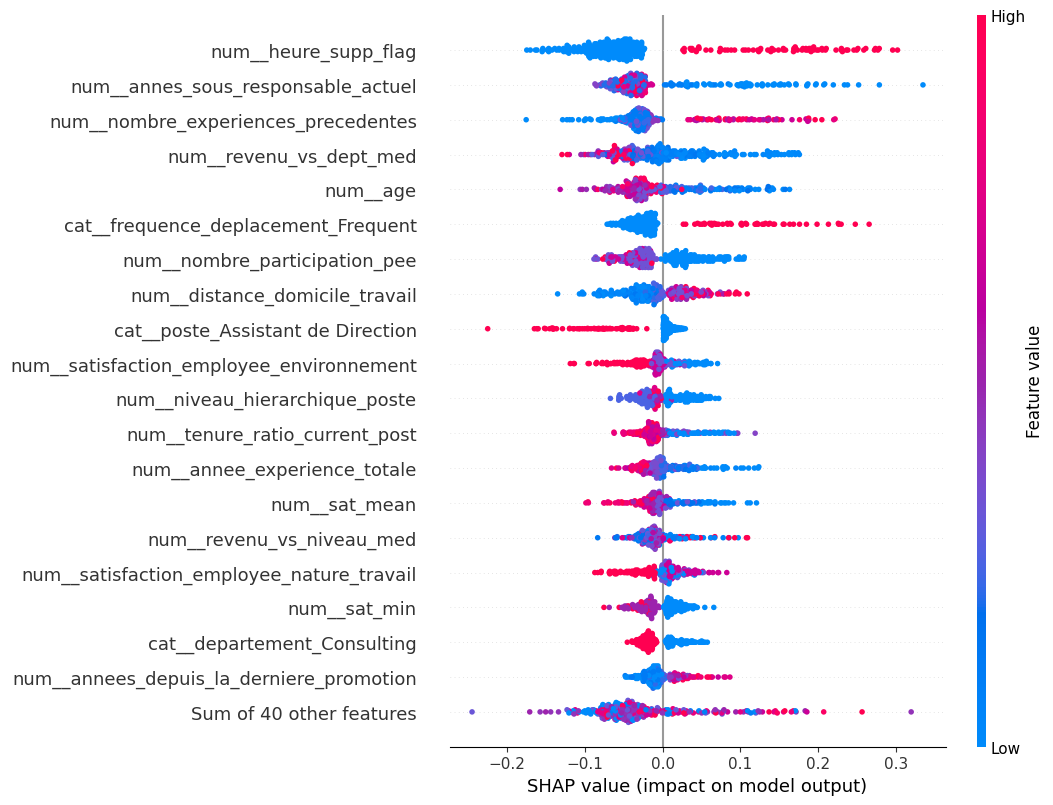

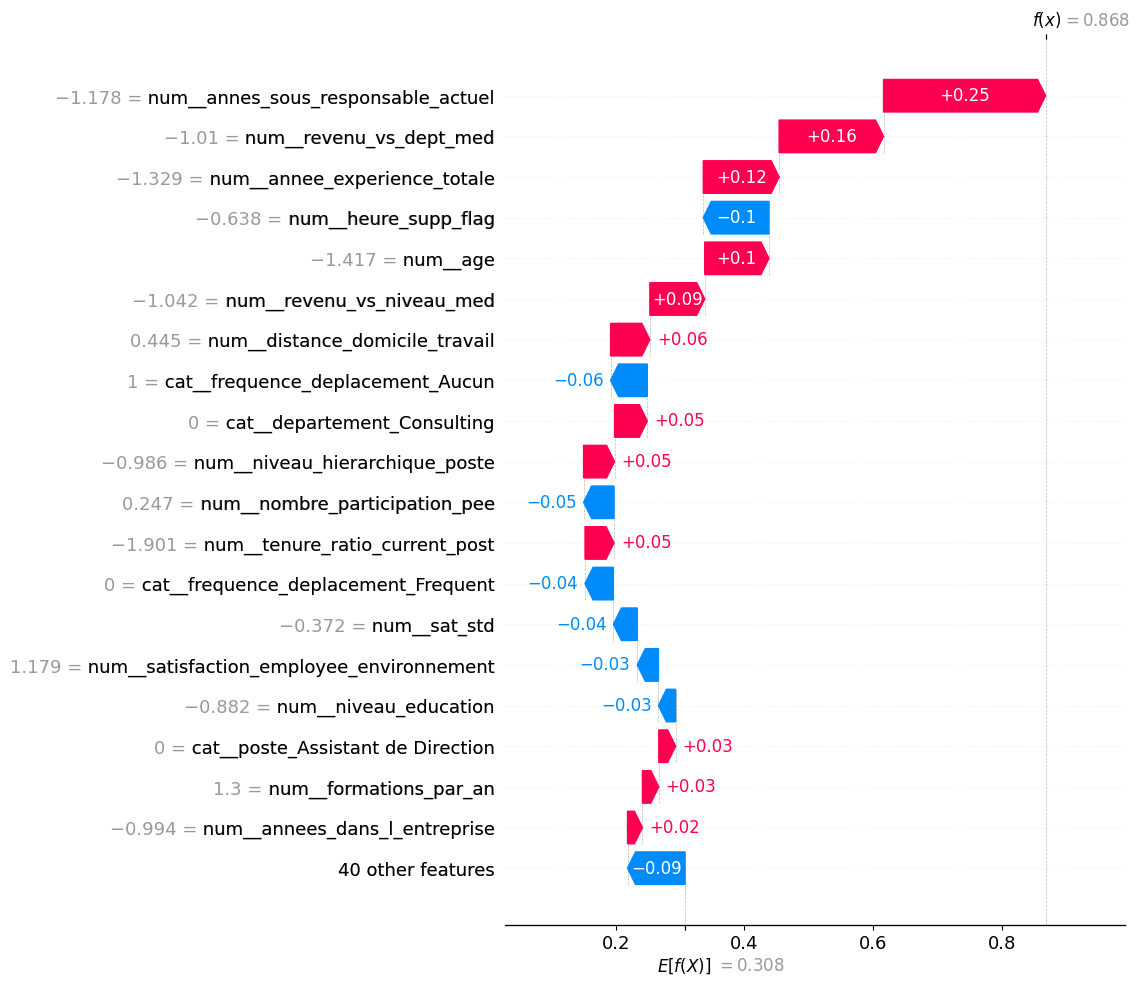


Top-25 features (|SHAP| moyen) :
                                       feature  mean_abs_shap
                          num__heure_supp_flag       0.093425
            num__annes_sous_responsable_actuel       0.060045
           num__nombre_experiences_precedentes       0.051499
                       num__revenu_vs_dept_med       0.048668
                                      num__age       0.044240
           cat__frequence_deplacement_Frequent       0.043835
                 num__nombre_participation_pee       0.037797
                num__distance_domicile_travail       0.034106
             cat__poste_Assistant de Direction       0.026363
      num__satisfaction_employee_environnement       0.024188
                num__niveau_hierarchique_poste       0.022859
                num__tenure_ratio_current_post       0.022170
                  num__annee_experience_totale       0.021607
                                 num__sat_mean       0.021479
                     num__revenu_vs_

In [148]:
# ===============================================================
# SHAP sur un Pipeline sklearn (fe -> drop -> prep -> xgb)
# ===============================================================
import numpy as np
import pandas as pd
from scipy import sparse
import shap

# 0) Hypothèse: pipe_XG est DEJA fit, et X_train / X_test existent.

# 1) Récupération des étapes utiles
fe   = pipe_XG.named_steps["fe"]     # ton FeatureEngineer() déjà fit
#drop = pipe_XG.named_steps["drop"]   # ton ColumnDropper() déjà fit
prep = pipe_XG.named_steps["prep"]   # ton ColumnTransformer déjà fit
xgb  = pipe_XG.named_steps["xgb"]    # l'estimateur final (XGBClassifier / HistGB / RF ...)

# 2) Fonction utilitaire: projeter X brut -> espace features du modèle
def to_model_space(X):
    X2 = fe.transform(X)             # mêmes features qu'au fit
    #X2 = drop.transform(X2)          # mêmes colonnes retirées qu'au fit
    Z  = prep.transform(X2)          # encodage + scaling identiques
    if sparse.issparse(Z):           # (beaucoup de ploteurs SHAP préfèrent du dense)
        Z = Z.toarray()
    cols = prep.get_feature_names_out()  # noms post-encodage (scikit-learn >= 1.0)
    return pd.DataFrame(Z, columns=cols)

# 3) Construire les matrices transformées train/test comme “vues” par le modèle
Xtr_df = to_model_space(X_train)
Xte_df = to_model_space(X_test)

# 4) Explainer SHAP pour modèles d’arbres
#    - background = petit échantillon du train transformé (plus rapide/stable)
background = shap.sample(Xtr_df, 200, random_state=42)
explainer = shap.TreeExplainer(
    xgb,
    data=background,
    feature_perturbation="interventional",   # robuste pour les arbres
    model_output="probability"               # SHAP sur l’échelle proba (sinon log-odds)
)

# 5) Valeurs SHAP sur le TEST (check_additivity=False pour éviter un warning XGB)
shap_values = explainer(Xte_df, check_additivity=False)

# 6) Plots globaux/local (adapter max_display au besoin)
# Global : importance + sens d'effet
shap.plots.beeswarm(shap_values, max_display=20)

# Local : explication d’un individu i
i = 0  # changer l’index pour parcourir des exemples
shap.plots.waterfall(shap_values[i], max_display=20)

# 7) (Option) Exporter l’importance moyenne absolue par feature
imp_df = (
    pd.DataFrame({
        "feature": Xte_df.columns,
        "mean_abs_shap": np.abs(shap_values.values).mean(axis=0)
    })
    .sort_values("mean_abs_shap", ascending=False)
)
print("\nTop-25 features (|SHAP| moyen) :")
print(imp_df.head(25).to_string(index=False))

# 8) (Option) Agréger par variable source (avant OHE) si tu utilises un schéma "num__" / "cat__"
#    Regroupe toutes les dummies d’une même variable d’origine (somme des |SHAP|)
def source_from_feature_name(name: str) -> str:
    # Exemple d’extractions: "num__age" -> "age" ; "cat__poste_Manager" -> "poste"
    if name.startswith("num__"):
        return name.split("num__", 1)[1].split("_", 1)[0] if "__" in name else name[5:]
    if name.startswith("cat__"):
        base = name.split("cat__", 1)[1]
        return base.split("_", 1)[0]   # avant le premier "_", ex: "poste_Manager" -> "poste"
    return name

agg_df = (
    imp_df.assign(source=imp_df["feature"].map(source_from_feature_name))
          .groupby("source", as_index=False)["mean_abs_shap"].sum()
          .sort_values("mean_abs_shap", ascending=False)
)
print("\nTop-20 variables sources (agrégation des dummies par somme |SHAP|) :")
print(agg_df.head(20).to_string(index=False))


In [160]:
# ===============================================================
# XGBoost + (option) SMOTE/Under + GridSearch + Seuil PR + (option) Calibration
# ===============================================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# ---------------- scikit-learn / imblearn / xgboost ----------------
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    precision_recall_curve, precision_recall_fscore_support,
    accuracy_score, balanced_accuracy_score
)
from sklearn.calibration import CalibratedClassifierCV

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

# ===============================================================
# 0) Paramètres généraux à ajuster
# ===============================================================
RANDOM_STATE = 42

# Choix de stratégie d'équilibrage
USE_SMOTE = True          # True => SMOTE+UnderSampler ; False => pas de resampling
SMOTE_RATIO = 0.20        # ratio cible (minorité / majorité) pour SMOTE
UNDER_RATIO = 0.50        # ratio cible (minorité / majorité) après under-sampling

# Calibration des probabilités (isotonic ou sigmoid). Mets True si tu veux calibrer
USE_CALIBRATION = False
CALIB_METHOD = "isotonic"  # "isotonic" (plus souple) ou "sigmoid" (Platt)

# Objectif business (seuil)
USE_TARGET_RECALL = True   # True => choisir un seuil pour atteindre un rappel cible
RECALL_TARGET = 0.80       # rappel cible
# Si False => on prendra le seuil qui maximise F1 (sur OOF)

# ===============================================================
# 1) Utilitaires (seuils & évaluations)
# ===============================================================
def get_positive_scores(model, X):
    """Retourne un score pour la classe positive (1): predict_proba[:,1] sinon decision_function."""
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        s = model.decision_function(X)
        if s.ndim == 1:
            return s
        # Multi-sorties: essaye d'attraper la colonne de la classe 1
        pos_idx = -1
        if hasattr(model, "classes_"):
            cls = np.array(model.classes_)
            idx = np.where(cls == 1)[0]
            if len(idx):
                pos_idx = int(idx[0])
        return s[:, pos_idx]
    else:
        raise AttributeError("Le modèle ne fournit ni predict_proba ni decision_function.")

def evaluate_at_threshold(y_true, scores, thr):
    y_pred = (scores >= thr).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    ap = average_precision_score(y_true, scores)
    roc = roc_auc_score(y_true, scores)
    cm = confusion_matrix(y_true, y_pred)  # [[tn, fp],[fn, tp]]
    rep = classification_report(y_true, y_pred, digits=3, zero_division=0)
    return {
        "threshold": float(thr),
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "accuracy": float(acc),
        "balanced_accuracy": float(bacc),
        "avg_precision_pr": float(ap),
        "roc_auc": float(roc),
        "confusion_matrix": cm,
        "report": rep
    }

def pick_threshold(y_true, scores, mode="max_f1", recall_target=0.75):
    """
    Choisit un seuil depuis la courbe PR (F1-max ou rappel cible), via precision_recall_curve (sklearn).
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, scores)
    # Alignement: thresholds a une longueur len(precisions)-1
    P, R, T = precisions[:-1], recalls[:-1], thresholds
    F1 = np.where((P + R) > 0, 2 * P * R / (P + R), 0.0)

    if mode == "max_f1":
        idx = int(np.nanargmax(F1))
    elif mode == "target_recall":
        feas = np.where(R >= recall_target)[0]
        idx = int(feas[np.nanargmax(F1[feas])]) if len(feas) else int(np.nanargmax(F1))
    else:
        raise ValueError("mode doit être 'max_f1' ou 'target_recall'")

    return float(T[idx]), {
        "chosen_mode": mode,
        "recall_target": recall_target if mode == "target_recall" else None,
        "threshold": float(T[idx]),
        "precision": float(P[idx]),
        "recall": float(R[idx]),
        "f1": float(F1[idx]),
        "avg_precision_pr": float(average_precision_score(y_true, scores)),
        "roc_auc": float(roc_auc_score(y_true, scores)),
    }

def pick_threshold_oof(model, X_train, y_train, mode="max_f1", recall_target=0.75, n_splits=5, random_state=42):
    """
    Choix de seuil sur des scores OOF (out-of-fold) pour éviter toute fuite sur le test.
    """
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_scores = cross_val_predict(model, X_train, y_train, cv=cv, method="predict_proba")[:, 1]
    thr, summary = pick_threshold(y_train, oof_scores, mode=mode, recall_target=recall_target)
    return float(thr), summary

# ===============================================================
# 2) (Option) FE / ColumnDropper — adaptables, safe par défaut
# ===============================================================
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Exemples de features (laisse 'pass' si tu n'en veux pas)."""
    def fit(self, X, y=None): return self
    def transform(self, X):
        X2 = X.copy()
        # -- exemples non activés (à adapter à ton jeu) --
        # if {"note_evaluation_actuelle", "note_evaluation_precedente"} <= set(X2.columns):
        #     X2["delta_note_evaluation"] = X2["note_evaluation_actuelle"] - X2["note_evaluation_precedente"]
        # if {"satisfaction_employee_nature_travail", "satisfaction_employee_environnement",
        #     "satisfaction_employee_equipe", "satisfaction_employee_equilibre_pro_perso"} <= set(X2.columns):
        #     sats = X2[[
        #         "satisfaction_employee_nature_travail",
        #         "satisfaction_employee_environnement",
        #         "satisfaction_employee_equipe",
        #         "satisfaction_employee_equilibre_pro_perso"
        #     ]].astype(float)
        #     X2["sat_mean"] = sats.mean(axis=1)
        #     X2["sat_min"]  = sats.min(axis=1)
        #     X2["sat_std"]  = sats.std(axis=1)
        X2 = X2.replace([np.inf, -np.inf], np.nan)
        return X2

from sklearn.base import BaseEstimator, TransformerMixin

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        # Ne rien modifier ici : on stocke tel quel
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # On prépare une copie SANS toucher à self.columns
        cols = [] if self.columns is None else list(self.columns)
        to_drop = [c for c in cols if c in X.columns]
        return X.drop(columns=to_drop, errors="ignore")

# Liste vide par défaut — tu peux remettre tes colonnes à exclure si besoin
cols_a_supprimer = [ 
    #"hors_entreprise_majoritaire", 
    #"perf_degrade_flag", 
    #"a_connu_mvmnt_interne", 
    #"genre",
    #"heure_supplementaires",
    #"pee_participation_2plus", 
    #"revenu_mensuel"
    ]

# ===============================================================
# 3) Données & split
# ===============================================================
# On part d'un DataFrame `data` avec une cible 'a_quitte_l_entreprise' ("Non"/"Oui")
data_pd = data.copy()
X = data_pd.drop(columns=["a_quitte_l_entreprise"])
y = data_pd["a_quitte_l_entreprise"].map({"Non": 0, "Oui": 1}).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

# ===============================================================
# 4) Préprocessing (imputer+scale num, imputer+OHE cat)
#     NB: on laisse OHE même pour XGBoost pour rester simple & compatible SMOTE
# ===============================================================
numeric_sel = selector(dtype_include=["number", "bool"])
categorical_sel = selector(dtype_exclude=["number", "bool"])

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_sel),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_sel),
    ],
    remainder="drop"
)

# ===============================================================
# 5) XGBClassifier + (option) SMOTE/Under + GridSearchCV
# ===============================================================
# Option alternative au SMOTE: scale_pos_weight = (#neg/#pos) recommandé par XGBoost
def compute_scale_pos_weight(y):
    pos = (y == 1).sum()
    neg = (y == 0).sum()
    return float(neg) / float(pos) if pos > 0 else 1.0

base_xgb_params = dict(
    objective="binary:logistic",
    eval_metric="aucpr",          # pertinent quand classes déséquilibrées
    tree_method="hist",           # rapide
    random_state=RANDOM_STATE,
    n_jobs=-1
)

if not USE_SMOTE:
    base_xgb_params["scale_pos_weight"] = compute_scale_pos_weight(y_train)  # cf. doc XGBoost

xgb_clf = XGBClassifier(**base_xgb_params)

if USE_SMOTE:
    # IMPORTANT : imblearn.Pipeline pour chaîner des resamplers
    pipe = ImbPipeline(steps=[
        ("fe", FeatureEngineer()),
        ("drop", ColumnDropper(columns=cols_a_supprimer)),
        ("prep", preprocess),
        ("over", SMOTE(sampling_strategy=SMOTE_RATIO, k_neighbors=5, random_state=RANDOM_STATE)),
        ("under", RandomUnderSampler(sampling_strategy=UNDER_RATIO, random_state=RANDOM_STATE)),
        ("xgb", xgb_clf),
    ])
else:
    pipe = Pipeline(steps=[
        ("fe", FeatureEngineer()),
        ("drop", ColumnDropper(columns=cols_a_supprimer)),
        ("prep", preprocess),
        ("xgb", xgb_clf),
    ])

# Grille XGB "raisonnable" (pas trop grosse) — on refit sur AP (PR-AUC)
param_grid = {
    "xgb__n_estimators": [400, 800],
    "xgb__learning_rate": [0.03, 0.08, 0.15],
    "xgb__max_depth": [3, 4, 5],
    "xgb__min_child_weight": [1, 3, 5],
    "xgb__subsample": [0.7, 0.9, 1.0],
    "xgb__colsample_bytree": [0.7, 0.9, 1.0],
    "xgb__reg_alpha": [0.0, 0.1],
    "xgb__reg_lambda": [1.0, 2.0, 5.0],
    # "xgb__gamma": [0.0, 0.1],  # à activer si tu veux durcir le split
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"ap": "average_precision", "roc_auc": "roc_auc"}

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scoring,
    refit="ap",            # on refit sur la meilleure AP (PR-AUC)
    cv=cv,
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)
print("\n=== Meilleurs hyperparamètres (refit=AP) ===")
print(gs.best_params_)
print(f"Meilleure AP (CV) : {gs.best_score_:.4f}")

best_model = gs.best_estimator_

# ===============================================================
# 6) (option) Calibration des probabilités
#     ⚠️ Idéalement faire la calibration sur un split de validation séparé.
#     Ici on illustre avec cv=5 pour limiter la fuite.
# ===============================================================
if USE_CALIBRATION:
    calibrator = CalibratedClassifierCV(
        base_estimator=best_model,
        method=CALIB_METHOD,
        cv=5
    )
    calibrator.fit(X_train, y_train)
    final_model = calibrator
else:
    final_model = best_model

# ===============================================================
# 7) Choix de seuil SANS regarder le test (OOF sur le TRAIN)
# ===============================================================
mode = "target_recall" if USE_TARGET_RECALL else "max_f1"
thr_oof, thr_summary = pick_threshold_oof(
    final_model, X_train, y_train,
    mode=mode, recall_target=RECALL_TARGET,
    n_splits=5, random_state=RANDOM_STATE
)
print("\n=== Seuil choisi (OOF) ===")
print(thr_summary)

# ===============================================================
# 8) Évaluation finale sur TEST
# ===============================================================
# refit final sur tout le TRAIN (GridSearchCV l’a déjà fait sur folds; on refit encore par sécurité)
final_model.fit(X_train, y_train)

# Scores seuil-indépendants
proba_test = get_positive_scores(final_model, X_test)
print("\n=== AUC/AP sur test (seuil-indépendant) ===")
print("ROC AUC (test) :", f"{roc_auc_score(y_test, proba_test):.3f}")
print("Avg Precision (test) :", f"{average_precision_score(y_test, proba_test):.3f}")

# Rapport au seuil OOF
res = evaluate_at_threshold(y_test, proba_test, thr_oof)
print(f"\n=== Rapport @ seuil OOF ({mode}) ===")
print(f"Seuil: {res['threshold']:.4f}")
print(res["report"])
print("Confusion matrix [[tn, fp],[fn, tp]]:\n", res["confusion_matrix"])

# (Option diagnostic) point F1-max sur le TEST (ne PAS geler ce seuil en production)
prec, rec, thr = precision_recall_curve(y_test, proba_test)
P, R, T = prec[:-1], rec[:-1], thr
F1 = (2 * P * R) / (P + R + 1e-12)
ix = int(np.nanargmax(F1))
print("\n[INFO] Test F1-max (diagnostic) : "
      f"thr={T[ix]:.4f} | P={P[ix]:.3f} R={R[ix]:.3f} F1={F1[ix]:.3f}")


Fitting 5 folds for each of 2916 candidates, totalling 14580 fits

=== Meilleurs hyperparamètres (refit=AP) ===
{'xgb__colsample_bytree': 0.7, 'xgb__learning_rate': 0.03, 'xgb__max_depth': 3, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 400, 'xgb__reg_alpha': 0.1, 'xgb__reg_lambda': 5.0, 'xgb__subsample': 0.7}
Meilleure AP (CV) : 0.6257

=== Seuil choisi (OOF) ===
{'chosen_mode': 'target_recall', 'recall_target': 0.8, 'threshold': 0.22616691887378693, 'precision': 0.3125, 'recall': 0.8157894736842105, 'f1': 0.45189504373177836, 'avg_precision_pr': 0.6119170286004407, 'roc_auc': 0.8273513398099713}

=== AUC/AP sur test (seuil-indépendant) ===
ROC AUC (test) : 0.800
Avg Precision (test) : 0.489

=== Rapport @ seuil OOF (target_recall) ===
Seuil: 0.2262
              precision    recall  f1-score   support

           0      0.955     0.684     0.797       247
           1      0.333     0.830     0.476        47

    accuracy                          0.707       294
   macro avg     